In [27]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os


In [28]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 100
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16


In [29]:


BUFFER_SIZE = 60000
BATCH_SIZE = 256

(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1)
train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5

train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE)


In [30]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                               padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                               padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                               padding='same', use_bias=False, activation='tanh')
    ])
    return model


In [31]:
generator = make_generator_model()


In [32]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2),
                      padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [33]:
discriminator = make_discriminator_model()


In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [36]:
def discriminator_accuracy(real_output, fake_output):
    real_pred = tf.cast(real_output > 0, tf.float32)
    fake_pred = tf.cast(fake_output < 0, tf.float32)

    real_acc = tf.reduce_mean(real_pred)
    fake_acc = tf.reduce_mean(fake_pred)

    return (real_acc + fake_acc) / 2.0


def generator_accuracy(fake_output):
    fake_pred = tf.cast(fake_output > 0, tf.float32)
    return tf.reduce_mean(fake_pred)


In [37]:
@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    generator_optimizer.apply_gradients(
        zip(gen_tape.gradient(gen_loss, generator.trainable_variables),
            generator.trainable_variables))

    discriminator_optimizer.apply_gradients(
        zip(disc_tape.gradient(disc_loss, discriminator.trainable_variables),
            discriminator.trainable_variables))

    d_acc = discriminator_accuracy(real_output, fake_output)
    g_acc = generator_accuracy(fake_output)

    return d_acc, g_acc


In [38]:
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

def save_images(epoch):
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    os.makedirs("gan_images", exist_ok=True)
    plt.savefig(f"gan_images/image_epoch_{epoch:03d}.png")
    plt.close()


In [39]:
for epoch in range(1, EPOCHS + 1):

    d_acc_list = []
    g_acc_list = []

    for image_batch in train_dataset:
        d_acc, g_acc = train_step(image_batch)
        d_acc_list.append(d_acc)
        g_acc_list.append(g_acc)

    avg_d_acc = tf.reduce_mean(d_acc_list)
    avg_g_acc = tf.reduce_mean(g_acc_list)

    save_images(epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"D Accuracy: {avg_d_acc:.4f} | "
        f"G Accuracy: {avg_g_acc:.4f}"
    )


Epoch 1/100 | D Accuracy: 0.7456 | G Accuracy: 0.4568
Epoch 2/100 | D Accuracy: 0.7006 | G Accuracy: 0.2937
Epoch 3/100 | D Accuracy: 0.7976 | G Accuracy: 0.1868
Epoch 4/100 | D Accuracy: 0.6845 | G Accuracy: 0.2930
Epoch 5/100 | D Accuracy: 0.6937 | G Accuracy: 0.2877
Epoch 6/100 | D Accuracy: 0.6469 | G Accuracy: 0.3273
Epoch 7/100 | D Accuracy: 0.6624 | G Accuracy: 0.3234
Epoch 8/100 | D Accuracy: 0.6384 | G Accuracy: 0.3488
Epoch 9/100 | D Accuracy: 0.6878 | G Accuracy: 0.2829
Epoch 10/100 | D Accuracy: 0.6773 | G Accuracy: 0.3125
Epoch 11/100 | D Accuracy: 0.6795 | G Accuracy: 0.2979
Epoch 12/100 | D Accuracy: 0.7236 | G Accuracy: 0.2530
Epoch 13/100 | D Accuracy: 0.6902 | G Accuracy: 0.2929
Epoch 14/100 | D Accuracy: 0.7120 | G Accuracy: 0.2734
Epoch 15/100 | D Accuracy: 0.7337 | G Accuracy: 0.2471
Epoch 16/100 | D Accuracy: 0.7069 | G Accuracy: 0.2802
Epoch 17/100 | D Accuracy: 0.7219 | G Accuracy: 0.2622
Epoch 18/100 | D Accuracy: 0.7346 | G Accuracy: 0.2456
Epoch 19/100 | D Ac

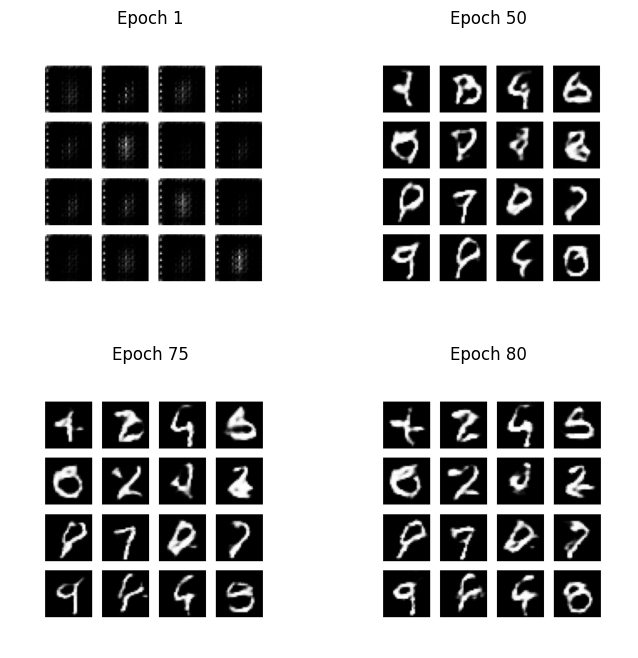

In [47]:
import matplotlib.pyplot as plt
import os

epochs_to_show = [1, 50, 75, 80]
image_folder = "gan_images"

plt.figure(figsize=(8, 8))

for i, epoch in enumerate(epochs_to_show):
    img_path = os.path.join(
        image_folder, f"image_epoch_{epoch:03d}.png"
    )

    if os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis("off")
    else:
        print(f"Image not found for Epoch {epoch} -> {img_path}")

plt.show()
